In [78]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

from sklearn.feature_selection import RFECV
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
train = pd.read_csv('C:/Users/Abhishek/Desktop/ml_comps/applied-data-analysis/Applied-Data-Analysis/animal-shelter/data/train.csv/train.csv', parse_dates=['DateTime'])
test = pd.read_csv('C:/Users/Abhishek/Desktop/ml_comps/applied-data-analysis/Applied-Data-Analysis/animal-shelter/data/test.csv/test.csv', parse_dates=['DateTime'])
sub = pd.read_csv('C:/Users/Abhishek/Desktop/ml_comps/applied-data-analysis/Applied-Data-Analysis/animal-shelter/data/sample_submission.csv/sample_submission.csv')

In [3]:
train_features = ['animal_id', 'name', 'date_time', 'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome',
                'age_upon_outcome', 'breed', 'color']

test_features = ['id', 'name', 'date_time', 'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed',
                 'color']

train.columns = train_features
test.columns = test_features

In [4]:
train.head()

,animal_id,name,date_time,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
test.head()

,id,name,date_time,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


## Preprocessing

In [6]:
# convert date time to day, month, year, weekday

train['day'] = train.date_time.dt.day
train['month'] = train.date_time.dt.month
train['year'] = train.date_time.dt.year
train['week_day'] = train.date_time.dt.weekday

test['day'] = test.date_time.dt.day
test['month'] = test.date_time.dt.month
test['year'] = test.date_time.dt.year
test['week_day'] = test.date_time.dt.weekday

In [7]:
# fix age_upon_outcome to convert all of the values to days

def fix_age_upon_outcome(age):
    if not pd.isnull(age):
        age_vals = age.split()
        
        val = int(age_vals[0])
        age_type = age_vals[1]
        
        if age_type == 'year' or age_type == 'year' :
            val *= 365
        elif age_type == 'month' or age_type == 'months':
            val *= 30
        return val
    else:
        return np.nan

train['age_upon_outcome'] = train.age_upon_outcome.map(fix_age_upon_outcome)
test['age_upon_outcome'] = test.age_upon_outcome.map(fix_age_upon_outcome)

# fill in missing values with -999
train['age_upon_outcome'] = train.age_upon_outcome.fillna(-999)
test['age_upon_outcome'] = test.age_upon_outcome.fillna(-999)

In [8]:
# Convert breed to a binary variable to say whether this is a mixed breed or not

def is_mixed(breed):
    breed = breed.lower()
    
    if 'mix' in breed:
        return 1
    else:
        return 0

train['is_mixed'] = train.breed.map(is_mixed)
test['is_mixed'] = test.breed.map(is_mixed)

In [9]:
# Create a multi color variable

def is_multi_color(color):
    if len(color.split('/')) > 1:
        return 1
    else:
        return 0

train['is_multi_color'] = train.color.map(is_multi_color)
test['is_multi_color'] = test.color.map(is_multi_color)

In [10]:
# indicator for animal type ( dog = 1, cat = 0 )

def get_animal_type( animal_type ):
    if animal_type == 'Dog':
        return 1
    else:
        return 0

train['animal_type_indicator'] = train.animal_type.map(get_animal_type)
test['animal_type_indicator'] = test.animal_type.map(get_animal_type)

In [11]:
# encode sex upon outcome 

def encode_sex_upon_outcome(train, test):
    data = pd.concat([train.sex_upon_outcome, test.sex_upon_outcome])
    lbl = LabelEncoder()
    
    lbl.fit(data)
    
    train['sex_upon_outcome'] = lbl.transform(train.sex_upon_outcome)
    test['sex_upon_outcome'] = lbl.transform(test.sex_upon_outcome)
    
    return train, test

train, test = encode_sex_upon_outcome(train, test)

In [12]:
# encode outcome type

def encode_outcome_type(train):
    lbl = LabelEncoder()
    
    train['outcome_type_encoded'] = lbl.fit_transform(train.outcome_type)
    
    return train, lbl

train, encoder = encode_outcome_type(train)

## Exploratory Data Analysis

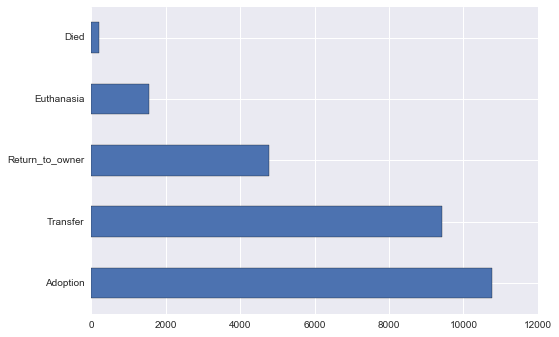

In [13]:
# Different types of outcomes
train.outcome_type.value_counts().plot(kind='barh');

** Most of the animals were either adopted or transferred. **

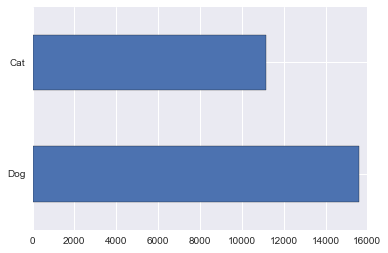

In [45]:
# animal type
train.animal_type.value_counts().plot(kind='barh');

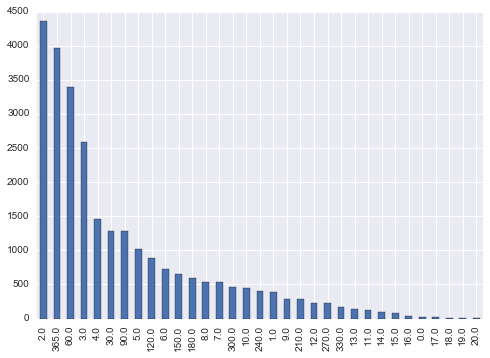

In [9]:
# age upon outcome
train.age_upon_outcome.value_counts().plot(kind='bar');

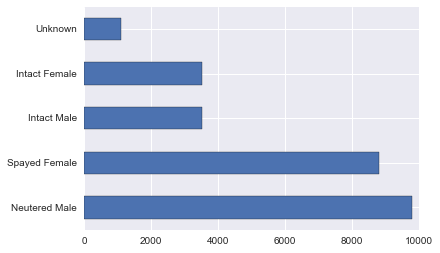

In [48]:
# sex upon outcome
train.sex_upon_outcome.value_counts().plot(kind='barh');

In [49]:
# breed
train.breed.value_counts()

Domestic Shorthair Mix                     8810
Pit Bull Mix                               1906
Chihuahua Shorthair Mix                    1766
Labrador Retriever Mix                     1363
Domestic Medium Hair Mix                    839
German Shepherd Mix                         575
Domestic Longhair Mix                       520
Siamese Mix                                 389
Australian Cattle Dog Mix                   367
Dachshund Mix                               318
Boxer Mix                                   245
Miniature Poodle Mix                        233
Border Collie Mix                           229
Australian Shepherd Mix                     163
Rat Terrier Mix                             157
Catahoula Mix                               157
Jack Russell Terrier Mix                    146
Yorkshire Terrier Mix                       143
Domestic Shorthair                          143
Chihuahua Longhair Mix                      142
Siberian Husky Mix                      

In [50]:
# color
train.color.value_counts()

Black/White                  2824
Black                        2292
Brown Tabby                  1635
Brown Tabby/White             940
White                         931
Brown/White                   884
Orange Tabby                  841
Tan/White                     773
Tricolor                      752
Blue/White                    702
Black/Tan                     672
White/Black                   643
Brown                         639
Tan                           628
White/Brown                   569
Tortie                        530
Calico                        517
Orange Tabby/White            455
Brown Brindle/White           450
Blue                          450
Black/Brown                   436
Blue Tabby                    433
White/Tan                     389
Red                           337
Torbie                        335
Brown/Black                   333
Red/White                     331
Blue Tabby/White              241
Brown Brindle                 232
Chocolate/Whit

## Relationship between outcome and age

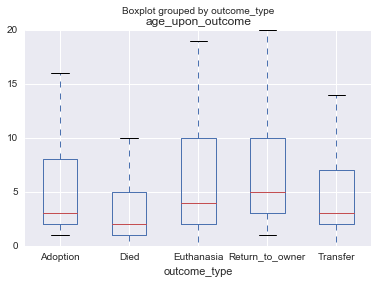

In [55]:
train.boxplot(column='age_upon_outcome', by='outcome_type');

## Relationship between outcome and sex

In [56]:
pd.crosstab(train.outcome_type, train.sex_upon_outcome)

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
outcome_type,,,,,
Adoption,203,158,5222,5186,0
Died,56,79,19,18,25
Euthanasia,401,477,344,232,101
Return_to_owner,301,477,2247,1748,12
Transfer,2550,2334,1947,1636,955


## Relationship between animal type and outcome type

In [57]:
pd.crosstab(train.animal_type, train.outcome_type)

outcome_type,Adoption,Died,Euthanasia,Return_to_owner,Transfer
animal_type,,,,,
Cat,4272,147,710,500,5505
Dog,6497,50,845,4286,3917


In [16]:
features = ['animal_type_indicator', 'sex_upon_outcome', 'age_upon_outcome', 'is_mixed', 'is_multi_color',\
            'day', 'month', 'year', 'week_day']
X = train[features]
y = train.outcome_type_encoded

## Model Building

In [14]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A Majorty vote ensemble classifier
    """
    
    def __init__(self, classifiers, vote='probability', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for 
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Fit classifiers
        """
        
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self
    
    def predict(self, X):
        """
        Predict the class labels for X.
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.classifierspredict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        """
        
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba
    
    def get_params(self, deep=True):
        """
        Get classifier parameter names for Grid Search
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' %(name, key)] = value
            
            return out

## Feature Selection

In [28]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True)

# estimator = RandomForestClassifier() # ['sex_upon_outcome' 'age_upon_outcome']
# estimator = LogisticRegression() # ['animal_type_indicator' 'sex_upon_outcome' 'age_upon_outcome' 'is_mixed'\
                                 # 'is_multi_color' 'day' 'month' 'week_day']
    
# estimator = GradientBoostingClassifier() # ['animal_type_indicator' 'sex_upon_outcome' 'age_upon_outcome' 'day'
                                        #  'month' 'year' 'week_day']
estimator = ExtraTreesClassifier() #   
selector = RFECV(estimator, step=1, cv=cv, scoring='log_loss')
selector = selector.fit(X, y)

In [22]:
selected_features = np.array(features)[selector.support_]

In [23]:
print 'selected features are %s ' %(selected_features)

selected features are ['animal_type_indicator' 'sex_upon_outcome' 'age_upon_outcome' 'day'
 'month' 'year' 'week_day'] 


## Train Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

## Modelling and Parameter Tuning

In [84]:
# random forest classifier
param_grid = [{
        'n_estimators': [10, 100, 500],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'log2', 'sqrt'],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
    }]

In [85]:
estimator = RandomForestClassifier()
skf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=32)
gs = GridSearchCV(estimator, param_grid=param_grid, scoring='log_loss', n_jobs=1, cv=skf)

In [ ]:
gs.fit(X, y)

### Majority Vote Estimators

In [74]:
majority_vote_estimator = MajorityVoteClassifier([GradientBoostingClassifier(),
                                                  RandomForestClassifier(n_estimators=100),
                                                  ExtraTreesClassifier(n_estimators=200),
                                                  XGBClassifier(),
                                                  LogisticRegression()
                                                 ], [.2, .2, .2, .3, .1])

In [75]:
majority_vote_estimator.fit(X_train, y_train)
predsTrain = majority_vote_estimator.predict_proba(X_train)

print 'Multi-Class Log loss for training examples %f ' %(log_loss(y_train, predsTrain))

Multi-Class Log loss for training examples 0.470015 


In [76]:
predsTest = majority_vote_estimator.predict_proba(X_test)

print 'Multi-Class Log loss for test examples %f ' %(log_loss(y_test, predsTest))

Multi-Class Log loss for test examples 0.894694 


In [47]:
majority_vote_estimator.fit(X, y)
predictions = majority_vote_estimator.predict_proba(test[features])

In [48]:
sub[sub.columns[1:]] = predictions

In [50]:
sub.to_csv('../submissions/majority_vote.csv', index=False)